In [ ]:
#Predicting the sum of Medicare fee–for–service reimbursements made during the calendar year for services covered by carrier claims from 2008-2010

In [ ]:
#LOADING DATA

In [144]:
!pip install pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel('Medicare/DE1_0_2008_Beneficiary_Summary_File_Sample_1.xlsx')

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [145]:
print(df)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [189]:
df = df.rename(columns={'DESYNPUF_ID': 'ID', 'BENE_BIRTH_DT':'Birth_Date', 'BENE_DEATH_DT':'Death_Date', 'BENE_SEX_IDENT_CD':'Sex',
                        'BENE_RACE_CD':'RACE', 'SP_STATE_CODE':'State_Code', 'BENE_ESRD_IND':'End_Renal',
                        'BENE_HI_CVRAGE_TOT_MONS':'Total_Months_PartA', 'BENE_SMI_CVRAGE_TOT_MONS':'Total_Months_PartB',
                       'BENE_HMO_CVRAGE_TOT_MONS':'Total_Months_HMO', 'PLAN_CVRG_MOS_NUM':'Total_Months_PartD'})

In [104]:
print(df)

                      ID  Birth_Date  Death_Date  Sex  RACE End_Renal  \
0       00013D2EFD8E45D1    19230501         NaN    1     1         0   
1       00016F745862898F    19430101         NaN    1     1         0   
2       0001FDD721E223DC    19360901         NaN    2     1         0   
3       00021CA6FF03E670    19410601         NaN    1     5         0   
4       00024B3D2352D2D0    19360801         NaN    1     1         0   
...                  ...         ...         ...  ...   ...       ...   
116347  FFFD7C464C94D136    19430701         NaN    2     1         0   
116348  FFFE3ED9582AD46E    19160601         NaN    2     1         0   
116349  FFFE7AB5D7F1725D    19390401         NaN    2     1         0   
116350  FFFF29A2E1362059    19110701         NaN    1     1         0   
116351  FFFF7C107A4E385A    19520401         NaN    2     1         0   

        State_Code  BENE_COUNTY_CD  Total_Months_PartA  Total_Months_PartB  \
0               26             950           

In [191]:
df['End_Renal'] = df['End_Renal'].replace('Y', 1)

In [193]:
MEDREIMB_CAR = df.pop('MEDREIMB_CAR')

In [195]:
df['MEDREIMB_CAR'] = MEDREIMB_CAR

In [205]:
X = df.iloc[:, 3:-1].values
y = df.iloc[:, -1:].values

In [253]:
#One Hot Encoding categorical data
#Encoding the Independent Variables

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(),[0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
     

In [251]:
df.describe()

,Birth_Date,Death_Date,Sex,RACE,End_Renal,State_Code,BENE_COUNTY_CD,Total_Months_PartA,Total_Months_PartB,Total_Months_HMO,Total_Months_PartD,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,BENRES_CAR,PPPYMT_CAR,MEDREIMB_CAR
count,1.163520e+05,1.814000e+03,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000
mean,1.936418e+07,2.008065e+07,1.553037,1.284662,0.071000,25.693740,366.486188,11.143994,10.495514,2.576183,6.826466,1.807395,1.715046,1.839401,1.936271,1.864695,1.786510,1.621322,1.579363,1.826587,1.846019,1.955110,2214.180762,249.053441,99.142258,622.226520,197.502235,25.724182,328.747508,18.355851,1162.095881
std,1.250446e+05,3.493908e+02,0.497181,0.754885,0.256826,15.582601,266.106008,2.839995,3.758701,4.828831,5.814787,0.394347,0.451395,0.367162,0.244271,0.342050,0.409773,0.485060,0.493664,0.378606,0.360932,0.207063,8473.340573,885.356400,1857.930522,1796.476653,522.437900,370.974324,436.858441,87.356293,1587.643182
min,1.909010e+07,2.008010e+07,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-3000.000000,0.000000,0.000000,-90.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.928110e+07,2.008030e+07,1.000000,1.000000,0.000000,10.000000,140.000000,12.000000,12.000000,0.000000,0.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.936050e+07,2.008070e+07,2.000000,1.000000,0.000000,25.000000,330.000000,12.000000,12.000000,0.000000,12.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,170.000000,0.000000,610.000000
75%,1.942030e+07,2.008100e+07,2.000000,1.000000,0.000000,39.000000,560.000000,12.000000,12.000000,0.000000,12.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,550.000000,180.000000,0.000000,480.000000,0.000000,1650.000000
max,1.983120e+07,2.008120e+07,2.000000,5.000000,1.000000,54.000000,999.000000,12.000000,12.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,164220.000000,53096.000000,68000.000000,50020.000000,12450.000000,14400.000000,5260.000000,2110.000000,21160.000000


In [255]:
print(X)

[[  1.   0.   1. ...   0.   0.   0.]
 [  1.   0.   1. ...   0. 240.   0.]
 [  0.   1.   1. ...   0.   0.   0.]
 ...
 [  0.   1.   1. ...   0.   0.   0.]
 [  1.   0.   1. ...   0.   0.   0.]
 [  0.   1.   1. ...   0. 910.   0.]]


In [223]:
print(y)

[[   0]
 [ 700]
 [   0]
 ...
 [   0]
 [   0]
 [3280]]


In [257]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [257]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [259]:
print(X_train)

[[1.00e+00 0.00e+00 1.00e+00 ... 0.00e+00 2.20e+02 2.00e+01]
 [0.00e+00 1.00e+00 1.00e+00 ... 0.00e+00 8.70e+02 0.00e+00]
 [0.00e+00 1.00e+00 1.00e+00 ... 0.00e+00 2.15e+03 6.00e+01]
 ...
 [0.00e+00 1.00e+00 1.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [1.00e+00 0.00e+00 1.00e+00 ... 0.00e+00 2.50e+02 0.00e+00]
 [1.00e+00 0.00e+00 1.00e+00 ... 0.00e+00 6.90e+02 0.00e+00]]


In [261]:
print(y_train)

[[ 600]
 [5140]
 [7190]
 ...
 [   0]
 [ 820]
 [1420]]


Training the Multiple Linear Regression model on the Training set

In [263]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
LinearRegression()

LinearRegression()

Predicting the Test set results

In [265]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[ -13.32    0.  ]
 [7165.07 8070.  ]
 [1319.86 1110.  ]
 ...
 [ -12.03    0.  ]
 [ -13.65    0.  ]
 [ -13.94    0.  ]]


Evaluating the Model Performance

In [267]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9410253528562273

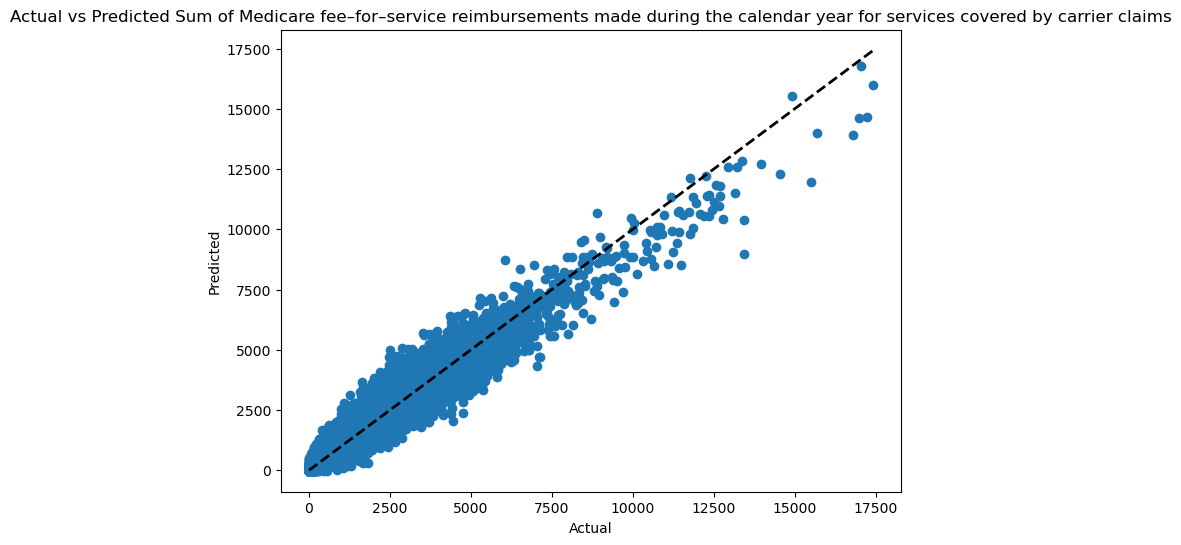

In [277]:
# Visualizing predictions versus actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Sum of Medicare fee–for–service reimbursements made during the calendar year for services covered by carrier claims')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

This plot compares the actual reimbursements (x-axis) to the predicted reimbursements (y-axis) for the Medicare fee-for-service claims.
Ideally, the points should align along a diagonal line (y=x), indicating that predicted values closely match the actual values.
If the points mostly cluster around the line, it suggests that the model is making accurate predictions.
Dispersed or spread-out points away from the line may indicate discrepancies between actual and predicted values.